In [4]:
import json
import pandas as pd

# Load JSON
with open("models/final/features.json", "r") as f:
    data = json.load(f)

# Convert to DataFrame (assuming list of dicts)
df = pd.DataFrame(data)

# Preview
print(df.head())


            0
0    hour_sin
1    hour_cos
2     dow_sin
3     dow_cos
4  is_holiday


for app implementation:

- all data used for input into the feature engineering, look at APIs+Data/data.ipynb for what api i used to collect
- feature engineering must be done in the backend as well 

Load the raw data (CSV or real-time API).

Apply the same feature engineering pipeline that produced features.json.

Convert to DataFrame using only those columns listed in features.json.

Load the model.

Call model.predict(X).

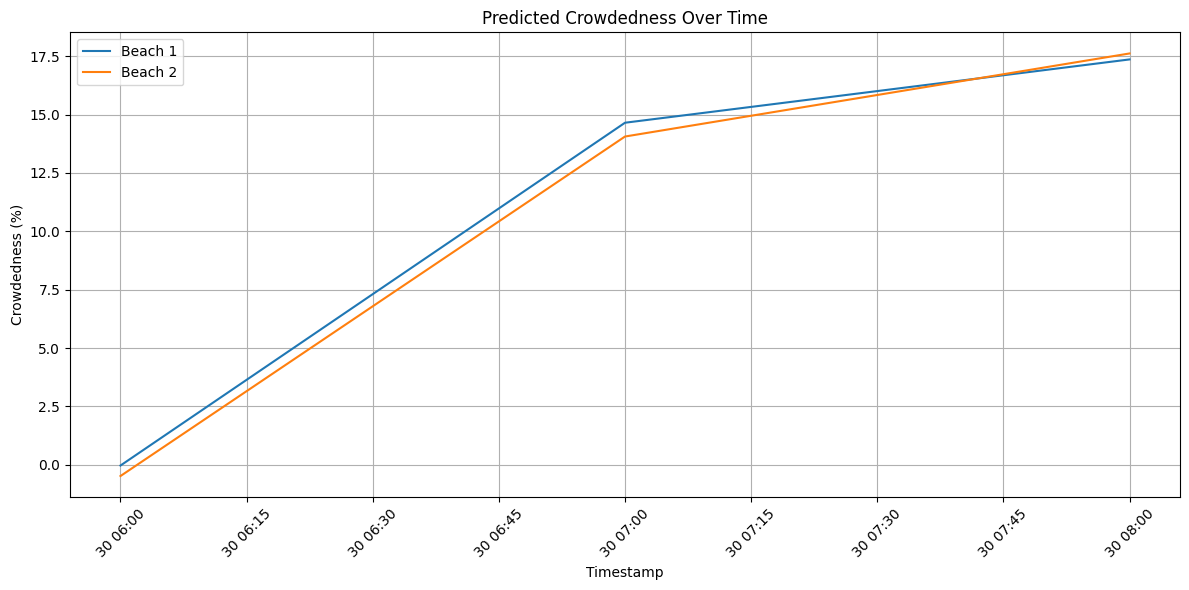

In [7]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the trained model
model = xgb.XGBRegressor()
model.load_model("models/final/crowd_forecast_model.json")

# Load feature list
with open("models/final/features.json") as f:
    features = json.load(f)

# Load test data
df = pd.read_csv("test_data.csv", parse_dates=["timestamp"])

# Extract time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.weekday

# Cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Grouped lag and rolling features
df['crowdedness_lag_1'] = df.groupby('beach_id')['crowdedness_percentage'].shift(1)
df['crowdedness_roll_mean_3'] = (
    df.groupby('beach_id')['crowdedness_percentage']
    .rolling(3).mean().reset_index(0, drop=True)
)

# One-hot encode weather
weather_dummies = pd.get_dummies(df['weather'], prefix="weather")
df = pd.concat([df, weather_dummies], axis=1)

# Ensure all expected feature columns exist
for col in features:
    if col not in df:
        df[col] = 0

# Prepare final input data
X = df[features].fillna(0)

# Predict
df['predicted_crowdedness'] = model.predict(X)

# Plot
plt.figure(figsize=(12, 6))
for beach_id in df['beach_id'].unique():
    subset = df[df['beach_id'] == beach_id]
    plt.plot(subset['timestamp'], subset['predicted_crowdedness'], label=f'Beach {beach_id}')

plt.title("Predicted Crowdedness Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Crowdedness (%)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()
